In [19]:
import numpy as np
import TensorFrost as tf
import matplotlib.pyplot as plt

tf.initialize(tf.cpu)

def BitonicSort():
    input = tf.input([-1, 2], tf.int32) #key, value
    N = input.shape[0]

    output = tf.buffer([N, 2], tf.int32)
    i,j = output.indices
    output[i, j] = input[i, j]

    log2N = tf.ceil(tf.log2(tf.float(N)))
    Nround = tf.int(tf.exp2(log2N))
    steps = tf.int(log2N*(log2N + 1.0)/2.0)

    sort_id = tf.indices([Nround/2])[0]
    def sortingIteration(step):
        def getBitonicElementPair(id, step):
            j = tf.floor(tf.sqrt(tf.float(2*step) + 1.0) - 0.5)
            n = tf.round(tf.float(step) - 0.5*j*(j+1.0))
            B = tf.int(tf.round(tf.exp2(j-n)))
            mask = tf.select(n < 0.5, 2*B - 1, B)
            e1 = id%B + 2*B*(id/B)
            e2 = e1 ^ mask
            return e1, e2

        e1, e2 = getBitonicElementPair(sort_id, step)

        tf.if_cond((e1 >= N) | (e2 >= N), lambda: tf.continue_loop())

        key1, key2 = output[e1, 0], output[e2, 0]
        val1, val2 = output[e1, 1], output[e2, 1]
        
        def swap():
            output[e1, 0] = key2
            output[e2, 0] = key1
            output[e1, 1] = val2
            output[e2, 1] = val1

        tf.if_cond(key1 > key2, swap)

    tf.loop(sortingIteration, 0, steps, 1)

    return [output]

sort_program = tf.compile(BitonicSort)

BitonicSort:
  Kernel count: 2
  Intermediate buffers: 0
  Lines of generated code: 406



Error: 0


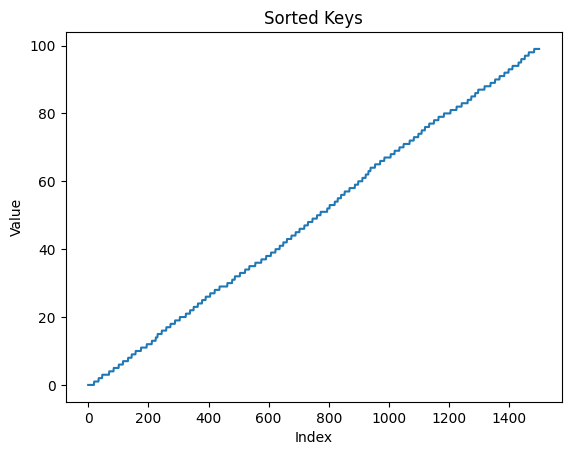

In [20]:
# Generate some random values
N = 1500
np.random.seed(0)
keys = np.random.randint(0, 100, N)
values = np.arange(N)

# Sort the keys
data = np.column_stack((keys, values))
data_tf = tf.tensor(data)
sorted_data, = sort_program(data_tf)
sorted_data = sorted_data.numpy

# Sort the keys using numpy
data = data[data[:, 0].argsort()]

# Compare the results
error = np.sum(np.abs(sorted_data[:, 0] - data[:, 0]))
print('Error:', error)

# Plot the sorted keys
plt.plot(sorted_data[:, 0])
plt.title('Sorted Keys')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()